In [ ]:
# default_exp ranker

In [ ]:
from tensorflow import one_hot

In [ ]:
# export
from multiinstance.data.gaussian_dg import GaussianMixtureDataGenerator

import matplotlib.pyplot as plt

from dist_curve.transforms import getOptimalTransform

from sklearn.metrics import roc_auc_score

from tqdm.notebook import tqdm,trange

import numpy as np

from sklearn.model_selection import train_test_split

import tensorflow as tf

# from multiinstance.density_ratio_em import DensityRatioEM

from multiinstance.nnpu import getPosterior

from easydict import EasyDict
from sklearn.model_selection import StratifiedKFold

In [ ]:
dg = GaussianMixtureDataGenerator(10,1,[0.8,.9],1000,10000)

In [ ]:
[xPU,yPU,yPN] = dg.pu_data()

In [ ]:
# xPUTrain,xPUVal,yPUTrain,yPUVal,yPNTrain,yPNVal = train_test_split(xPU,yPU,yPN)

xPUTrain,xPUVal,yPUTrain,yPUVal,yPNTrain,yPNVal = train_test_split(xPU,yPU,yPN,test_size=.2)
yPUTrain= yPUTrain[:,0].astype(bool)
posTrain = xPUTrain[yPUTrain]
uTrain = xPUTrain[~yPUTrain]
posidxs = np.random.choice(np.arange(posTrain.shape[0]),size=uTrain.shape[0],replace=True)
xpos = posTrain[posidxs]
xPUTrain = np.concatenate((xpos,uTrain))
yPUTrain = np.concatenate((np.ones(uTrain.shape[0]),
                           np.zeros(uTrain.shape[0])))

In [ ]:
from sklearn.metrics import dcg_score

# RankNet

In [ ]:
# export
class RankNet:
    def buildModel(self,input_shape):
        layers = tf.keras.models.Sequential([
            tf.keras.layers.Dense(64,activation="relu"),
            tf.keras.layers.Dense(64,activation="relu"),
            tf.keras.layers.Dense(64,activation="relu"),
            tf.keras.layers.Dense(1)
        ],name="dense_layers")
        inp1 = tf.keras.layers.Input(shape=(input_shape,),name="input_1")
        inp2 = tf.keras.layers.Input(shape=(input_shape,),name="input_2")
        score_1 = layers(inp1)
        score_2 = layers(inp2)
        score_diff = tf.keras.layers.Subtract()([score_1, score_2])
        prob = tf.keras.layers.Activation("sigmoid")(score_diff)
        self.model = tf.keras.models.Model(inputs=[inp1,inp2],outputs=prob)
        self.ranker = tf.keras.backend.function([inp1],[score_1])
        self.model.compile(tf.keras.optimizers.Adam(learning_rate=1e-4),
                           loss=tf.keras.losses.BinaryCrossentropy())

    def train(self,xPU,yPU,NIters=1000, batch_size=128,):
        skf = StratifiedKFold()
        ranks = np.zeros(xPU.shape[0])
        for trainIndices,valIndices in skf.split(xPU,yPU):
            xPUTrain,xPUVal,yPUTrain,yPUVal = xPU[trainIndices],xPU[valIndices],yPU[trainIndices],yPU[valIndices]
            ranks[valIndices] = self.trainFold(xPUTrain,xPUVal,yPUTrain,yPUVal,NIters,batch_size)
        print(roc_auc_score(yPU,ranks))
        return ranks

    def trainFold(self,xPUTrain,xPUVal,yPUTrain,yPUVal,NIters=10000, batch_size=128,):
        batchesPerEpoch = np.ceil(xPUTrain.shape[0] / batch_size).astype(int) # +/- rounding error
        self.buildModel(xPUTrain.shape[1])
        # Early stopping variables
        minvalLoss,patience = np.inf,0
        posTrain,unlabeledTrain = xPUTrain[yPUTrain],xPUTrain[~yPUTrain]
        posVal,unlabeledVal = xPUVal[yPUVal],xPUVal[~yPUVal]
        for iters in trange(NIters,leave=False):
            idxs1 = np.random.randint(0,high=posTrain.shape[0],size=batch_size)
            idxs2 = np.random.randint(0,high=unlabeledTrain.shape[0],size=batch_size)
            posInputs,unlabeledInputs = posTrain[idxs1],unlabeledTrain[idxs2]
            inputs = np.stack([posInputs,unlabeledInputs],axis=-1)
            b = np.random.binomial(1,.5,inputs.shape[0]).astype(bool)
            inputs[b] = inputs[b][...,[1,0]]
            inp1,inp2 = inputs[...,0], inputs[...,1]
            target = ~b
            trainLoss = self.model.train_on_batch([inp1,inp2],target)
            if not iters % batchesPerEpoch:
                i1 = np.random.choice(range(xPUVal.shape[0]),replace=False,
                                       size=int(xPUVal.shape[0] / 2))
                i2 = np.random.choice(list(set(range(xPUVal.shape[0])) - set(i1)),size=i1.shape,replace=True)
                inp1,inp2 = xPUVal[i1],xPUVal[i2]
                y1,y2 = yPUVal[i1],yPUVal[i2]
                target = y1 > y2
                valLoss = self.model.evaluate([inp1,inp2],target)
                scores = self.ranker(xPUVal)
                if valLoss < minvalLoss:
                    print("minvalLoss, ",valLoss)
                    minvalLoss = valLoss
                    patience = 0
                else:
                    patience += 1
                if patience == 15:
                    break
        return self.ranker(xPUVal)[0].ravel()


In [ ]:
ranker = RankNet()
ranker.train(xPU,yPU[:,0].astype(bool))

35/35 [==============================] - 0s 1ms/step - loss: 0.6938
minvalLoss,  0.6938291788101196
35/35 [==============================] - 0s 985us/step - loss: 0.9695


35/35 [==============================] - 0s 865us/step - loss: 0.7079
minvalLoss,  0.7078577876091003
35/35 [==============================] - 0s 1ms/step - loss: 0.6924
minvalLoss,  0.692432165145874
35/35 [==============================] - 0s 1ms/step - loss: 0.6914
minvalLoss,  0.6913823485374451
35/35 [==============================] - 0s 1ms/step - loss: 0.6853
minvalLoss,  0.6852761507034302
35/35 [==============================] - 0s 1ms/step - loss: 0.7912


35/35 [==============================] - 0s 1ms/step - loss: 0.7062
minvalLoss,  0.7061920166015625
35/35 [==============================] - 0s 940us/step - loss: 0.6891
minvalLoss,  0.6891396045684814
35/35 [==============================] - 0s 1ms/step - loss: 0.6882
minvalLoss,  0.6882157325744629
35/35 [==============================] - 0s 656us/step - loss: 0.7463


35/35 [==============================] - 0s 848us/step - loss: 0.7019
minvalLoss,  0.701921820640564
35/35 [==============================] - 0s 1ms/step - loss: 0.6987
minvalLoss,  0.6987229585647583
35/35 [==============================] - 0s 740us/step - loss: 0.6941
minvalLoss,  0.6941278576850891
35/35 [==============================] - 0s 810us/step - loss: 0.6879
minvalLoss,  0.6878905892372131
35/35 [==============================] - 0s 1ms/step - loss: 0.7714


35/35 [==============================] - 0s 1ms/step - loss: 0.7092
minvalLoss,  0.7091952562332153
35/35 [==============================] - 0s 1ms/step - loss: 0.6969
minvalLoss,  0.696934163570404
35/35 [==============================] - 0s 1ms/step - loss: 0.6867
minvalLoss,  0.6867296695709229
35/35 [==============================] - 0s 941us/step - loss: 0.6813
minvalLoss,  0.6812660098075867
35/35 [==============================] - 0s 1ms/step - loss: 0.6801
minvalLoss,  0.6801368594169617
35/35 [==============================] - 0s 729us/step - loss: 0.7509
0.6939479000000001


array([-0.35241199,  1.79942989,  0.5105046 , ...,  0.18457247,
        0.32395381,  1.40347767])

In [ ]:
dcg_score(np.asarray([dg.pu_posterior(xPUVal)]),np.asarray([ranker.ranker(xPUVal)[0].ravel()]))

24.69086885485588

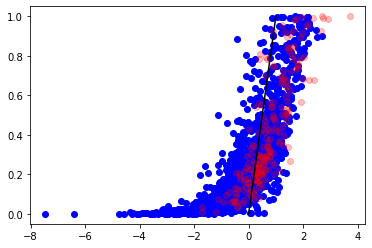

In [ ]:
plt.scatter(ranker.ranker(xPUVal[~yPUVal.ravel().astype(bool)])[0],dg.pn_posterior_cc(xPUVal[~yPUVal.ravel().astype(bool)]),color="blue")
plt.scatter(ranker.ranker(xPUVal[yPUVal.ravel().astype(bool)])[0],dg.pn_posterior_cc(xPUVal[yPUVal.ravel().astype(bool)]),color="red",alpha=.25)
plt.plot([0,1],[0,1],color="black")

In [ ]:
# export
class RankNet2:
    def buildModel(self,input_shape):

        def loss(t,diff):
            return (1-t) * (diff) - t * (diff)

        layers = tf.keras.models.Sequential([
            tf.keras.layers.Dense(128,activation="relu"),
            tf.keras.layers.Dense(128,activation="relu"),
            tf.keras.layers.Dense(128,activation="relu"),
            tf.keras.layers.Dense(1)
        ],name="dense_layers")
        inp1 = tf.keras.layers.Input(shape=(input_shape,),name="input_1")
        inp2 = tf.keras.layers.Input(shape=(input_shape,),name="input_2")
        score_1 = layers(inp1)
        score_2 = layers(inp2)
        score_diff = tf.keras.layers.Subtract()([score_1, score_2])
        prob = tf.keras.layers.Activation("sigmoid")(score_diff)
        self.model = tf.keras.models.Model(inputs=[inp1,inp2],outputs=score_diff)
        self.ranker = tf.keras.backend.function([inp1],[score_1])
        self.model.compile(tf.keras.optimizers.Adam(learning_rate=1e-4),
                           loss=loss)

    def train(self,xPU,yPU,NIters=5000, batch_size=128,):
        skf = StratifiedKFold()
        ranks = np.zeros(xPU.shape[0])
        for trainIndices,valIndices in skf.split(xPU,yPU):
            xPUTrain,xPUVal,yPUTrain,yPUVal = xPU[trainIndices],xPU[valIndices],yPU[trainIndices],yPU[valIndices]
            ranks[valIndices] = self.trainFold(xPUTrain,xPUVal,yPUTrain,yPUVal,NIters,batch_size)
        print(roc_auc_score(yPU,ranks))
        return ranks

    def trainFold(self,xPUTrain,xPUVal,yPUTrain,yPUVal,NIters=1000, batch_size=128,):
        batchesPerEpoch = np.ceil(xPUTrain.shape[0] / batch_size).astype(int) # +/- rounding error
        self.buildModel(xPUTrain.shape[1])
        # Early stopping variables
        minvalLoss,patience = np.inf,0
        posTrain,unlabeledTrain = xPUTrain[yPUTrain],xPUTrain[~yPUTrain]
        posVal,unlabeledVal = xPUVal[yPUVal],xPUVal[~yPUVal]
        for iters in trange(NIters,leave=False):
            idxs1 = np.random.randint(0,high=posTrain.shape[0],size=batch_size)
            idxs2 = np.random.randint(0,high=unlabeledTrain.shape[0],size=batch_size)
            posInputs,unlabeledInputs = posTrain[idxs1],unlabeledTrain[idxs2]
            inputs = np.stack([posInputs,unlabeledInputs],axis=-1)
            b = np.random.binomial(1,.5,inputs.shape[0]).astype(bool)
            inputs[b] = inputs[b][...,[1,0]]
            inp1,inp2 = inputs[...,0], inputs[...,1]
            target = ~b
            target = target.astype(float)
            trainLoss = self.model.train_on_batch([inp1,inp2],target)
            if not iters % batchesPerEpoch:
                i1 = np.random.choice(range(xPUVal.shape[0]),replace=False,
                                       size=int(xPUVal.shape[0] / 2))
                i2 = np.random.choice(list(set(range(xPUVal.shape[0])) - set(i1)),size=i1.shape,replace=True)
                inp1,inp2 = xPUVal[i1],xPUVal[i2]
                y1,y2 = yPUVal[i1],yPUVal[i2]
                target = (y1 > y2).astype(float)
                valLoss = self.model.evaluate([inp1,inp2],target)
                scores = self.ranker(xPUVal)
                if valLoss < minvalLoss:
                    print("minvalLoss, ",valLoss)
                    minvalLoss = valLoss
                    patience = 0
                else:
                    patience += 1
                if patience == 15:
                    break
        return self.ranker(xPUVal)[0].ravel()


In [ ]:
ranker3 = RankNet2()
ranker3.train(xPU,yPU[:,0].astype(bool))

35/35 [==============================] - 0s 1ms/step - loss: 3.9260e-05
minvalLoss,  3.926027784473263e-05
35/35 [==============================] - 0s 923us/step - loss: -0.0203
minvalLoss,  -0.020299648866057396
35/35 [==============================] - 0s 2ms/step - loss: -0.0331
minvalLoss,  -0.033074088394641876
35/35 [==============================] - 0s 1ms/step - loss: -0.9388
minvalLoss,  -0.938795268535614
35/35 [==============================] - 0s 2ms/step - loss: -1.0180
minvalLoss,  -1.0179767608642578
35/35 [==============================] - 0s 2ms/step - loss: -4.9128
minvalLoss,  -4.912788391113281
35/35 [==============================] - 0s 1ms/step - loss: -29.6905
minvalLoss,  -29.690465927124023
35/35 [==============================] - 0s 2ms/step - loss: -36.3336
minvalLoss,  -36.333580017089844
35/35 [==============================] - 0s 2ms/step - loss: -92.2625
minvalLoss,  -92.26253509521484
35/35 [==============================] - 0s 1ms/step - loss: -120.8590


35/35 [==============================] - 0s 1ms/step - loss: 0.0037
minvalLoss,  0.003716212697327137
35/35 [==============================] - 0s 2ms/step - loss: -0.0252
minvalLoss,  -0.025180788710713387
35/35 [==============================] - 0s 1ms/step - loss: -0.0384
minvalLoss,  -0.03837502375245094
35/35 [==============================] - 0s 2ms/step - loss: -0.0598
minvalLoss,  -0.059807002544403076
35/35 [==============================] - 0s 2ms/step - loss: -0.1564
minvalLoss,  -0.1564422845840454
35/35 [==============================] - 0s 2ms/step - loss: -0.3320
minvalLoss,  -0.3320118188858032
35/35 [==============================] - 0s 2ms/step - loss: -0.5698
minvalLoss,  -0.5697812438011169
35/35 [==============================] - 0s 1ms/step - loss: -0.9294
minvalLoss,  -0.9293625950813293
35/35 [==============================] - 0s 1ms/step - loss: -3.6292
minvalLoss,  -3.6292405128479004
35/35 [==============================] - 0s 1ms/step - loss: -4.8530
minvalLo

35/35 [==============================] - 0s 2ms/step - loss: -0.0032
minvalLoss,  -0.0032300336752086878
35/35 [==============================] - 0s 1ms/step - loss: -0.0184
minvalLoss,  -0.018375203013420105
35/35 [==============================] - 0s 2ms/step - loss: -0.0693
minvalLoss,  -0.06926333159208298
35/35 [==============================] - 0s 2ms/step - loss: -0.4354
minvalLoss,  -0.43537384271621704
35/35 [==============================] - 0s 1ms/step - loss: -0.4889
minvalLoss,  -0.4888984262943268
35/35 [==============================] - 0s 1ms/step - loss: -0.5614
minvalLoss,  -0.5613958835601807
35/35 [==============================] - 0s 1ms/step - loss: -4.0704
minvalLoss,  -4.07035493850708
35/35 [==============================] - 0s 1ms/step - loss: -12.6088
minvalLoss,  -12.60884952545166
35/35 [==============================] - 0s 1ms/step - loss: -22.5017
minvalLoss,  -22.501651763916016
35/35 [==============================] - 0s 2ms/step - loss: -37.3440
minval

35/35 [==============================] - 0s 1ms/step - loss: -0.0069
minvalLoss,  -0.006929949391633272
35/35 [==============================] - 0s 940us/step - loss: -0.0328
minvalLoss,  -0.0328228734433651
35/35 [==============================] - 0s 1ms/step - loss: -0.0545
minvalLoss,  -0.054454974830150604
35/35 [==============================] - 0s 1ms/step - loss: -0.1419
minvalLoss,  -0.14186324179172516
35/35 [==============================] - 0s 1ms/step - loss: -0.6005
minvalLoss,  -0.6004664897918701
35/35 [==============================] - 0s 1ms/step - loss: -1.7851
minvalLoss,  -1.7851026058197021
35/35 [==============================] - 0s 2ms/step - loss: -3.8823
minvalLoss,  -3.8822731971740723
35/35 [==============================] - 0s 2ms/step - loss: -10.6032
minvalLoss,  -10.603181838989258
35/35 [==============================] - 0s 1ms/step - loss: -10.8730
minvalLoss,  -10.873002052307129
35/35 [==============================] - 0s 1ms/step - loss: -17.1050
min

35/35 [==============================] - 0s 2ms/step - loss: 0.0012
minvalLoss,  0.0011569547932595015
35/35 [==============================] - 0s 2ms/step - loss: -0.0265
minvalLoss,  -0.02651931904256344
35/35 [==============================] - 0s 2ms/step - loss: -0.0955
minvalLoss,  -0.09551585465669632
35/35 [==============================] - 0s 2ms/step - loss: -0.1293
minvalLoss,  -0.12929697334766388
35/35 [==============================] - 0s 1ms/step - loss: -0.4259
minvalLoss,  -0.4259139597415924
35/35 [==============================] - 0s 1ms/step - loss: -0.6677
minvalLoss,  -0.6677072644233704
35/35 [==============================] - 0s 1ms/step - loss: -2.4396
minvalLoss,  -2.4395503997802734
35/35 [==============================] - 0s 1ms/step - loss: -5.7605
minvalLoss,  -5.760462760925293
35/35 [==============================] - 0s 2ms/step - loss: -7.8115
minvalLoss,  -7.811489582061768
35/35 [==============================] - 0s 1ms/step - loss: -24.4863
minvalLoss

array([-377969.       ,  265131.3125   ,  219250.34375  , ...,
        -61513.1640625,   76888.5234375,  295788.6875   ])

In [ ]:
dcg_score(np.asarray([dg.pu_posterior(xPUVal)]),np.asarray([ranker3.ranker(xPUVal)[0].ravel()]))

23.794100972776477

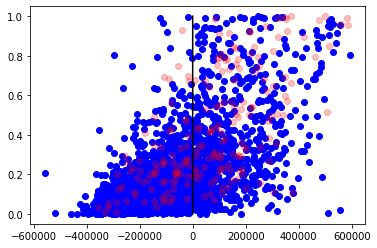

In [ ]:
plt.scatter(ranker3.ranker(xPUVal[~yPUVal.ravel().astype(bool)])[0],dg.pn_posterior_cc(xPUVal[~yPUVal.ravel().astype(bool)]),color="blue")
plt.scatter(ranker3.ranker(xPUVal[yPUVal.ravel().astype(bool)])[0],dg.pn_posterior_cc(xPUVal[yPUVal.ravel().astype(bool)]),color="red",alpha=.25)
plt.plot([0,1],[0,1],color="black")

In [ ]:
# export
class RankNetTies:
    def buildModel(self,input_shape):
        layers = tf.keras.models.Sequential([
            tf.keras.layers.Dense(128,activation="relu"),
            tf.keras.layers.Dense(128,activation="relu"),
            tf.keras.layers.Dense(128,activation="relu"),
            tf.keras.layers.Dense(1)
        ],name="dense_layers")
        inp1 = tf.keras.layers.Input(shape=(input_shape,),name="input_1")
        inp2 = tf.keras.layers.Input(shape=(input_shape,),name="input_2")
        score_1 = layers(inp1)
        score_2 = layers(inp2)
        score_diff = tf.keras.layers.Subtract()([score_1, score_2])
        prob = tf.keras.layers.Activation("sigmoid")(score_diff)
        self.model = tf.keras.models.Model(inputs=[inp1,inp2],outputs=prob)
        self.ranker = tf.keras.backend.function([inp1],[score_1])
        self.model.compile(tf.keras.optimizers.Adam(learning_rate=1e-4),
                           loss=tf.keras.losses.BinaryCrossentropy())

    def train(self,xPU,yPU,NIters=10000, batch_size=128,):
        skf = StratifiedKFold()
        ranks = np.zeros(xPU.shape[0])
        for trainIndices,valIndices in skf.split(xPU,yPU):
            xPUTrain,xPUVal,yPUTrain,yPUVal = xPU[trainIndices],xPU[valIndices],yPU[trainIndices],yPU[valIndices]
            ranks[valIndices] = self.trainFold(xPUTrain,xPUVal,yPUTrain,yPUVal,NIters,batch_size)
        print(roc_auc_score(yPU,ranks))
        return ranks

    def trainFold(self,xPUTrain,xPUVal,yPUTrain,yPUVal,NIters=10000, batch_size=128,):
        batchesPerEpoch = np.ceil(xPUTrain.shape[0] / batch_size).astype(int) # +/- rounding error
        self.buildModel(xPUTrain.shape[1])
        # Early stopping variables
        minvalLoss,patience = np.inf,0
#         posTrain,unlabeledTrain = xPUTrain[yPUTrain],xPUTrain[~yPUTrain]
#         posVal,unlabeledVal = xPUVal[yPUVal],xPUVal[~yPUVal]
        for iters in trange(NIters,leave=False):
            idxs1 = np.random.randint(0,high=xPUTrain.shape[0],size=batch_size)
            idxs2 = np.random.randint(0,high=xPUTrain.shape[0],size=batch_size)
            inp1 = xPUTrain[idxs1]
            inp2 = xPUTrain[idxs2]
            t1,t2 = yPUTrain[idxs1].ravel(),yPUTrain[idxs2].ravel()
            targets = np.zeros(idxs1.shape[0])
            targets[t1 == t2] = .5
            targets[t1 > t2] = 1
            trainLoss = self.model.train_on_batch([inp1,inp2],targets)
            if not iters % batchesPerEpoch:
                i1 = np.random.choice(range(xPUVal.shape[0]),replace=False,
                                       size=int(xPUVal.shape[0] / 2))
                i2 = np.random.choice(list(set(range(xPUVal.shape[0])) - set(i1)),size=i1.shape,replace=True)
                inp1,inp2 = xPUVal[i1],xPUVal[i2]
                y1,y2 = yPUVal[i1].ravel(),yPUVal[i2].ravel()
                targets = np.zeros(y1.shape[0]) 
                targets[y1 > y2] = 1
                targets[y1 == y2] = .5
                valLoss = self.model.evaluate([inp1,inp2],targets)
                scores = self.ranker(xPUVal)
                if valLoss < minvalLoss:
                    print("minvalLoss, ",valLoss)
                    minvalLoss = valLoss
                    patience = 0
                else:
                    patience += 1
                if patience == 15:
                    break
        return self.ranker(xPUVal)[0].ravel()


In [ ]:
ranker2 = RankNetTies()
ranker2.train(xPU,yPU)

35/35 [==============================] - 0s 2ms/step - loss: 0.7001
minvalLoss,  0.7000850439071655
35/35 [==============================] - 0s 2ms/step - loss: 0.6958
minvalLoss,  0.6958281993865967
35/35 [==============================] - 0s 2ms/step - loss: 0.7201


35/35 [==============================] - 0s 2ms/step - loss: 0.7008
minvalLoss,  0.7007820010185242
35/35 [==============================] - 0s 2ms/step - loss: 0.6924
minvalLoss,  0.692373514175415
35/35 [==============================] - 0s 2ms/step - loss: 0.6910
minvalLoss,  0.6909863948822021
35/35 [==============================] - 0s 2ms/step - loss: 0.6908
minvalLoss,  0.6907839179039001
35/35 [==============================] - 0s 2ms/step - loss: 0.6901
minvalLoss,  0.6901016235351562
35/35 [==============================] - 0s 1ms/step - loss: 0.6888
minvalLoss,  0.6887580752372742
35/35 [==============================] - 0s 2ms/step - loss: 0.6881
minvalLoss,  0.6880913376808167
35/35 [==============================] - 0s 1ms/step - loss: 0.6875
minvalLoss,  0.6874875426292419
35/35 [==============================] - 0s 1ms/step - loss: 0.6873
minvalLoss,  0.6872770190238953
35/35 [==============================] - 0s 752us/step - loss: 0.6872
minvalLoss,  0.6872207522392273

35/35 [==============================] - 0s 2ms/step - loss: 0.6928
minvalLoss,  0.6928136944770813
35/35 [==============================] - 0s 2ms/step - loss: 0.6888
minvalLoss,  0.6887965798377991
35/35 [==============================] - 0s 1ms/step - loss: 0.6881
minvalLoss,  0.6881129145622253
35/35 [==============================] - 0s 1ms/step - loss: 0.6872
minvalLoss,  0.6872178316116333
35/35 [==============================] - 0s 963us/step - loss: 0.6864
minvalLoss,  0.6863704323768616
35/35 [==============================] - 0s 769us/step - loss: 0.6851
minvalLoss,  0.6850988864898682
35/35 [==============================] - 0s 2ms/step - loss: 0.6849
minvalLoss,  0.6849006414413452
35/35 [==============================] - 0s 2ms/step - loss: 0.6841
minvalLoss,  0.6840513944625854
35/35 [==============================] - 0s 2ms/step - loss: 0.6860


35/35 [==============================] - 0s 1ms/step - loss: 0.6970
minvalLoss,  0.6969658136367798
35/35 [==============================] - 0s 2ms/step - loss: 0.6915
minvalLoss,  0.6914728879928589
35/35 [==============================] - 0s 2ms/step - loss: 0.6902
minvalLoss,  0.6901731491088867
35/35 [==============================] - 0s 1ms/step - loss: 0.6879
minvalLoss,  0.6879287362098694
35/35 [==============================] - 0s 1ms/step - loss: 0.6876
minvalLoss,  0.6875821352005005
35/35 [==============================] - 0s 1ms/step - loss: 0.6867
minvalLoss,  0.6867282390594482
35/35 [==============================] - 0s 2ms/step - loss: 0.6851
minvalLoss,  0.6850590705871582
35/35 [==============================] - 0s 1ms/step - loss: 0.6853


35/35 [==============================] - 0s 2ms/step - loss: 0.6958
minvalLoss,  0.6958010196685791
35/35 [==============================] - 0s 2ms/step - loss: 0.6914
minvalLoss,  0.6913654804229736
35/35 [==============================] - 0s 2ms/step - loss: 0.6893
minvalLoss,  0.6892818808555603
35/35 [==============================] - 0s 2ms/step - loss: 0.6883
minvalLoss,  0.688262939453125
35/35 [==============================] - 0s 2ms/step - loss: 0.6877
minvalLoss,  0.6877198815345764
35/35 [==============================] - 0s 2ms/step - loss: 0.6869
minvalLoss,  0.6869292259216309
35/35 [==============================] - 0s 1ms/step - loss: 0.6864
minvalLoss,  0.6864089369773865
35/35 [==============================] - 0s 1ms/step - loss: 0.6864
minvalLoss,  0.6863593459129333
35/35 [==============================] - 0s 1ms/step - loss: 0.6857
minvalLoss,  0.6856808066368103
35/35 [==============================] - 0s 1ms/step - loss: 0.6904
0.6635854


array([0.05745825, 0.5294652 , 0.01091731, ..., 0.0133664 , 0.00657031,
       0.39796197])

In [ ]:
dcg_score(np.asarray([dg.pu_posterior(xPUVal)]),np.asarray([ranker2.ranker(xPUVal)[0].ravel()]))

24.23470160453207

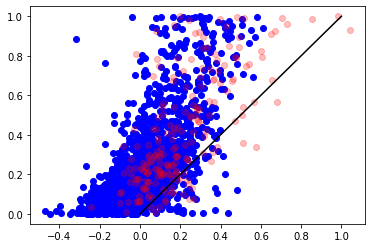

In [ ]:
plt.scatter(ranker2.ranker(xPUVal[~yPUVal.ravel().astype(bool)])[0],dg.pn_posterior_cc(xPUVal[~yPUVal.ravel().astype(bool)]),color="blue")
plt.scatter(ranker2.ranker(xPUVal[yPUVal.ravel().astype(bool)])[0],dg.pn_posterior_cc(xPUVal[yPUVal.ravel().astype(bool)]),color="red",alpha=.25)
plt.plot([0,1],[0,1],color="black")

### PN Posterior

In [ ]:
posts,net = getPosterior(xPU,yPU,dg.alpha,pupost=lambda x: ranker(x[:])[0],
             distributions=EasyDict({"true_posterior" : dg.pn_posterior_cc,
                                     "f1" : dg.dens_pos,
                                     "f0" : dg.dens_neg}),
             viz_freq=50,
             absLoss=True,
             yPN=yPN,
             training_args=EasyDict({"n_units": 128,
                                     "n_hidden":10,
                                     "dropout_rate":0.15,
                                     "maxIter":5000,
                                     "batch_size":128}),)

In [ ]:
print(roc_auc_score(yPNVal,dg.pn_posterior_cc(xPUVal)), roc_auc_score(yPNVal,net(ranker(xPUVal)[0])))

# Compare to the univariate transform score

In [ ]:
scores,aucpu = getOptimalTransform(xPU,yPU.ravel())

In [ ]:
aucpu

0.6362615

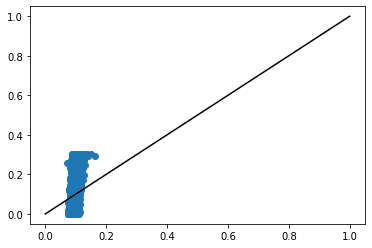

In [ ]:
plt.scatter(scores,dg.pu_posterior(xPU))
plt.plot([0,1],[0,1],color="black")

In [ ]:
roc_auc_score(yPU,scores)

0.6362615

### Training on scores

In [ ]:
posts,net = getPosterior(xPU,yPU,dg.alpha,inputs=scores[:,None],
             distributions=EasyDict({"true_posterior" : dg.pn_posterior_cc,
                                     "f1" : dg.dens_pos,
                                     "f0" : dg.dens_neg}),
             viz_freq=50,
             absLoss=True,
             yPN=yPN,
             training_args=EasyDict({"n_units": 128,
                                     "n_hidden":10,
                                     "dropout_rate":0.15,
                                     "maxIter":5000,
                                     "batch_size":128}),)

In [ ]:
roc_auc_score(yPN, net(scores[:,None]))

# No Transform

In [ ]:
getPosterior(xPU,yPU,dg.alpha,
             distributions=EasyDict({"true_posterior" : dg.pn_posterior_cc,
                                     "f1" : dg.dens_pos,
                                     "f0" : dg.dens_neg}),
             viz_freq=50,
             absLoss=True,
             yPN=yPN,
             training_args=EasyDict({"n_units": 128,
                                     "n_hidden":10,
                                     "dropout_rate":0.15,
                                     "maxIter":5000,
                                     "batch_size":128}),)

In [ ]:
import scipy.stats as ss

In [ ]:
from multiinstance.vpu import train

# Train on True Ranks

In [ ]:
ranks = ss.rankdata(dg.pu_posterior(xPU))[:,None]
ranks = (ranks - ranks.min()) / (ranks.max() - ranks.min())
p = getPosterior(xPU,yPU,dg.alpha,inputs=ranks[:,None],
             distributions=EasyDict({"true_posterior" : dg.pn_posterior_cc,
                                     "f1" : dg.dens_pos,
                                     "f0" : dg.dens_neg}),
             viz_freq=50,
             absLoss=True,
             yPN=yPN,
             training_args=EasyDict({"n_units": 128,
                                     "n_hidden":10,
                                     "dropout_rate":0.15,
                                     "maxIter":5000,
                                     "batch_size":128}),)

In [ ]:
roc_auc_score(yPN.astype(bool),p[0].ravel())

# VPU

In [ ]:
p = train(ranks[:,None],yPU.astype(bool),args=EasyDict({'hdim': 1024, 'lr': 0.0001, 'n_epochs': 500, 'batch_size': 32}),)

In [ ]:
plt.scatter(p,dg.pn_posterior_cc(xPU))
plt.plot([0,1],[0,1],color="black")

In [ ]:
roc_auc_score(yPN,p)

# XGBoost

In [ ]:
import xgboost

In [ ]:
xgb = xgboost.XGBRanker(n_estimators=1000,)

In [ ]:
xgb.fit(xPUTrain,yPUTrain[:,0],group=[yPUTrain.shape[0]])

In [ ]:
roc_auc_score(yPUVal, dg.pu_posterior(xPUVal))

In [ ]:
roc_auc_score(yPUVal,xgb.predict(xPUVal))

In [ ]:
plt.scatter(xgb.predict(xPUVal),dg.pu_posterior(xPUVal))
plt.plot([0,1],[0,1],color="black")

In [ ]:
xgbranks = xgb.predict(xPU)[:,None]
xgbranks = (xgbranks - xgbranks.min()) / (xgbranks.max() - xgbranks.min())

In [ ]:
getPosterior(xPU,yPU,dg.alpha,inputs=xgbranks,
             distributions=EasyDict({"true_posterior" : dg.pn_posterior_cc,
                                     "f1" : dg.dens_pos,
                                     "f0" : dg.dens_neg}),
             viz_freq=50,
             absLoss=True,
             yPN=yPN,
             training_args=EasyDict({"n_units": 128,
                                     "n_hidden":10,
                                     "dropout_rate":0.15,
                                     "maxIter":5000,
                                     "batch_size":128}),)